<a href="https://colab.research.google.com/github/Ortimus/AmazonSageMakerCourse/blob/master/PerformanceEvaluation/binary_classifier_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Evaluating Performance of a Binary Classifier
Binary Model is used for predicting a binary outcome (Pass/Fail, 1/0, True/False).

Some algorithms output a raw score that indicates probability of a sample belonging to positive class.

<q><i>The actual output of many binary classification algorithms is a prediction score. The score indicates the system’s certainty that the given observation belongs to the positive class</i></q><br>
Reference:
https://docs.aws.amazon.com/machine-learning/latest/dg/binary-classification.html

To convert this raw score to a positive or negative class, we need to specify a cut-off. A sample with score greater than the cut-off is classified as positive class and a sample with score less than the cut-off is classified as negative class.

To find out how good the model predictions are, we need to check predictions against previously unseen samples that were not used for training.  Usually, 30% of the available samples are reserved for testing while remaining 70% of samples are used for training.

By comparing predicted values against known results in test data, we can assess overall model performance<br>

In this first part, let's look at common metrics used for evaluating binary classifier performance.

In the second part, we will look at algorithms that produce raw scores and how model performs at different cut-off thresholds.

Common Techniques for evaluating performance:<br>
<li>Visually observe using Plots</li>
<li>Confusion Matrix</li>
<li>Evaluate with Metrics like Recall, Precision, Accuracy, False Alarm, F1-score, AUC Score</li>

<p>While Plots are good for humans to visually observe the results, we often need a single metric that can indicate quality of a model. This can be useful for programmatically identifying which model is performing better (for example: using automatic model tuning to select the best performing model)</p>

Reference:<br>https://docs.aws.amazon.com/machine-learning/latest/dg/binary-classification.html<br>
Confusion Matrix:<br>https://en.wikipedia.org/wiki/Confusion_matrix<br>

<h2>Binary Classifier Metrics</h2>
positive = number of actual positives (count)<br>
negative = number of actual negatives (count)<br>

True Positive = tp = how many samples were correctly classified as positive (count)<br>
True Negative = tn = how many samples were correctly classified as negative (count)<br>
False Positive = fp = how many negative samples were mis-classified as positive (count)<br>
False Negative = fn = how many positive samples were mis-classified as negative (count)<br>

<h4>True Positive Rate (TPR, Recall, Probability of detection) = True Positive/Positive</h4>
How many positives were correctly classified? (fraction)<br>
Recall value closer to 1 is better. closer to 0 is worse

<i>Example: Radar Operator watching the skies for enemy planes.
    
 Positive Class = Enemy Plane

 Negative Class = Friendly Plane

True Positive Rate or Probability of detection – is the probability of correctly classifying an enemy plane
</i>

<h4>True Negative Rate = True Negative/Negative</h4>
How many negatives were correctly classified? (fraction)<br>
True Negative Rate value closer to 1 is better. closer to 0 is worse

<i>True negative rate – is the probability of correctly classifying a friendly plane</i>
   
<h4>False Positive Rate (FPR, Probability of false alarm) = False Positive/Negative</h4>
How many negatives were mis-classified as positives (fraction)<br>
False Positive Rate value closer to 0 is better. closer to 1 is worse    

<i>Another name for this is Probability of false alarm – is the probability of mis-classifying a friendly plane as an enemy plane</i>
    
<h4>False Negative Rate (FNR, Misses) = False Negative/Positive</h4>
How many positives were mis-classified as negative (fraction)<br>
False Negative Rate value closer to 0 is better. closer to 1 is worse    
    
<i>False Negative Rate - is the probability of mis-classifying an enemy plane as a friendly plane</i>

<h4>Precision = True Positive/(True Positive + False Positive)</h4>
How many positives classified by the algorithm are really positives? (fraction)<br>
Precision value closer to 1 is better. closer to 0 is worse

<i>Precision would go up as enemy planes are correctly identified, while minimizing false alarm</i>
    
<h4>Accuracy = (True Positive + True Negative)/(Positive + Negative)</h4>
How many positives and negatives were correctly classified? (fraction)<br>
Accuracy value closer to 1 is better. closer to 0 is worse
        
<i>Accuracy would go up when enemy planes and friendly planes are correctly identified</i>

<h4>F1 Score = harmonic mean of Precision and Recall =  2*Precision*Recall / (Precision + Recall)</h4>
F1 Score closer to 1 is better. Closer to 0 is worse.

Reference:   
Harmonic Mean - https://en.wikipedia.org/wiki/Harmonic_mean <br>
Confusion Matrix - https://en.wikipedia.org/wiki/Confusion_matrix

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

<h2>Exam Result Data set</h2>
<h3>Columns</h3>
<li>Pass = Actual Pass or Fail for the sample. Pass=1, Fail=0</li>
<li>Model1_Prediction = Predicted Pass or Fail by model 1</li>
<li>Model2_Prediction = Predicted Pass or Fail by model 2</li>
<li>Model3_Prediction = Predicted Pass or Fail by model 3</li>
<li>Model4_Prediction = Predicted Pass or Fail by model 4</li>
<p>We are going to compare performance of these four models</p>

Hours Spent and Exam Result (Pass/Fail) Data set:<br>
https://en.wikipedia.org/wiki/Logistic_regression

In [2]:
# Clone the entire repository at the beginning of the notebook
# This will allow accessing local files from the repo
#!git clone https://github.com/Ortimus/AmazonSageMakerCourse.git

import os
import shutil

repo_name = "AmazonSageMakerCourse"
repo_url = "https://github.com/Ortimus/AmazonSageMakerCourse.git"

# Remove existing repo if it exists
if os.path.exists(repo_name):
    print(f"Removing existing repository {repo_name}...")
    shutil.rmtree(repo_name)

# Clone the repository fresh
print(f"Cloning repository {repo_name}...")
!git clone {repo_url}

Cloning repository AmazonSageMakerCourse...
Cloning into 'AmazonSageMakerCourse'...
remote: Enumerating objects: 962, done.
remote: Counting objects: 100% (306/306), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 962 (delta 254), reused 231 (delta 217), pack-reused 656 (from 1)
Receiving objects: 100% (962/962), 67.65 MiB | 12.52 MiB/s, done.
Resolving deltas: 100% (527/527), done.
Updating files: 100% (240/240), done.


In [3]:
models = ['Model 1','Model 2', 'Model 3', 'Model 4']
#df = pd.read_csv('HoursExamSample.csv')
df = pd.read_csv('./AmazonSageMakerCourse/PerformanceEvaluation/HoursExamSample.csv')

In [4]:
df

,Hours,Pass,Model1_Prediction,Model2_Prediction,Model3_Prediction,Model4_Prediction
0,0.50,0,0,0,0,1
1,0.75,0,0,0,0,1
2,1.00,0,0,0,0,1
3,1.25,0,0,0,0,1
4,1.50,0,0,0,0,1
5,1.75,0,1,0,0,1
6,1.75,1,1,0,0,1
7,2.00,0,1,0,0,1
8,2.25,1,1,0,0,1
9,2.50,0,1,0,0,1


## Plot Data
Compare performance visually <br>

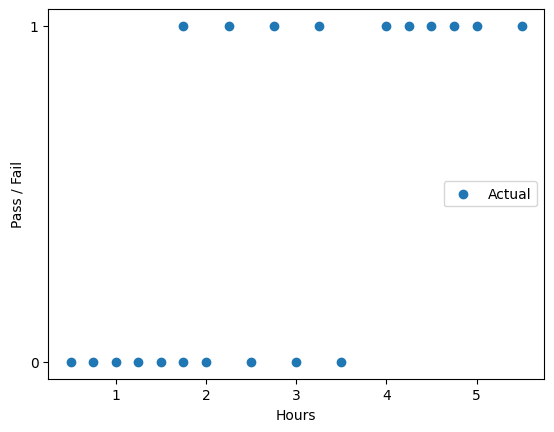

In [5]:
plt.figure()
plt.scatter(df['Hours'],df['Pass'],label='Actual')
plt.legend(loc=7)
plt.yticks([0,1])
plt.xlabel('Hours')
plt.ylabel('Pass / Fail')
plt.show()

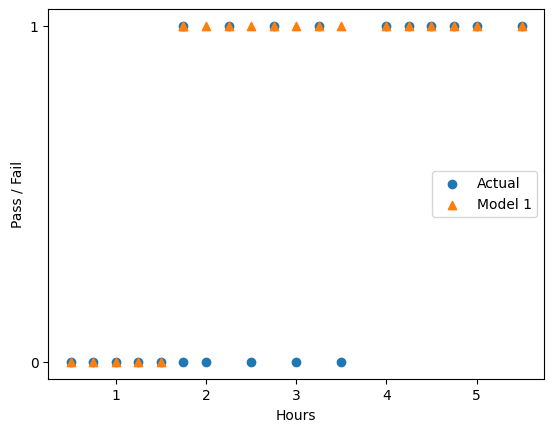

In [6]:
# Compare performance of Actual and Model 1 Prediction
plt.figure()
plt.scatter(df['Hours'],df['Pass'],label='Actual')
plt.scatter(df['Hours'],df['Model1_Prediction'],label='Model 1',marker='^')
plt.legend(loc=7)
plt.yticks([0,1])
plt.xlabel('Hours')
plt.ylabel('Pass / Fail')
plt.show()

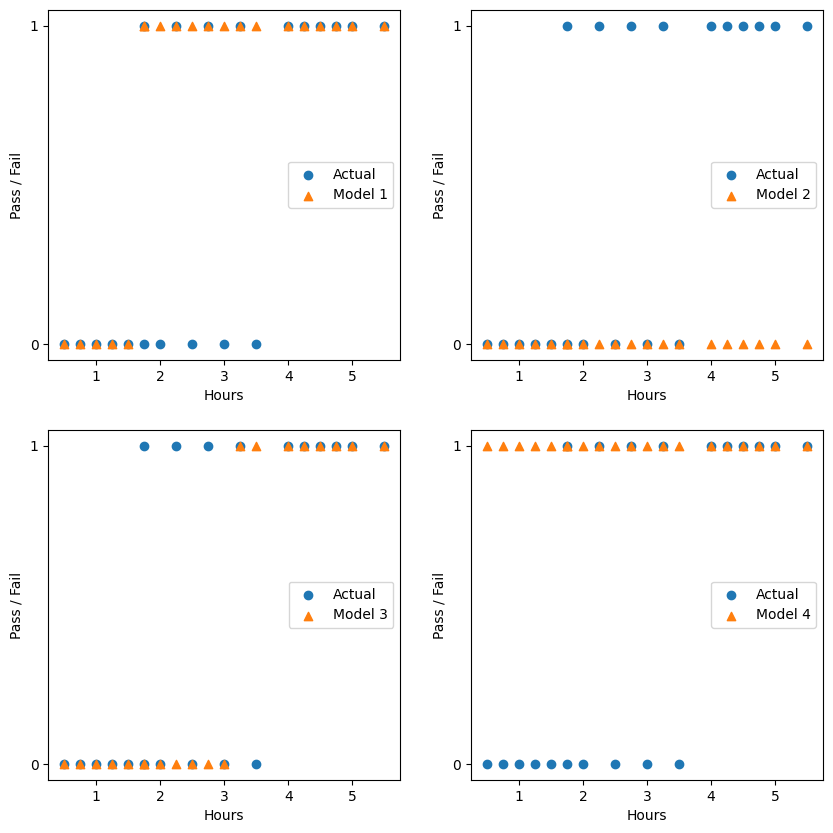

In [7]:
plt.figure(figsize=(10,10))

for idx, model in enumerate(models):
    plt.subplot(2,2,idx+1)

    plt.scatter(df['Hours'],df['Pass'],label='Actual')
    plt.scatter(df['Hours'],df[model.replace(' ','') + '_Prediction'],
                label=model,marker='^')
    plt.yticks([0,1])
    plt.legend(loc=7)
    plt.xlabel('Hours')
    plt.ylabel('Pass / Fail')

From the plots, we can observe that:<br>
<li>Model 1 is classifying samples as Pass if hours spent studying is greater than 1.5 hours</li>
<li>Model 2 is classifying all samples as Fail</li>
<li>Model 3 is classifying samples as Pass if hours spent studying is around 3 hours or more</li>
<li>Model 4 is classfying all samples as Pass</li>


<h2>Confusion Matrix</h2>
Confusion Matrix is a table that summarizes performance of classification model.<br><br>
It summarizes predictions into four categories:<br>
True Positive = tp = how many samples were correctly classified as positive (count)<br>
True Negative = tn = how many samples were correctly classified as negative (count)<br>
False Positive = fp = how many negative samples were mis-classified as positive (count)<br>
False Negative = fn = how many positive samples were mis-classified as negative (count)<br>
<br>
Using these four metrics, we can derive other useful metrics like Recall, Precision, Accuracy, F1-Score and so forth.<br>
<br>
Reference:<br>
https://en.wikipedia.org/wiki/Confusion_matrix

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
# Compute confusion matrix
# Compare Actual Vs Model 1 Predictions
cnf_matrix = confusion_matrix(df['Pass'],df['Model1_Prediction'],labels=[1,0])

In [10]:
cnf_matrix

array([[10,  0],
       [ 5,  5]])

In [11]:
# Reference: https://scikit-learn.org/stable/modules/model_evaluation.html
# Explicitly stating labels. Pass=1, Fail=0
def true_positive(y_true, y_pred):
    return confusion_matrix(y_true, y_pred,labels=[1,0])[0, 0]

def true_negative(y_true, y_pred):
    return confusion_matrix(y_true,y_pred,labels=[1,0])[1, 1]

def false_positive(y_true, y_pred):
    return confusion_matrix(y_true, y_pred,labels=[1,0])[1, 0]

def false_negative(y_true, y_pred):
    return confusion_matrix(y_true, y_pred,labels=[1,0])[0, 1]

In [12]:
# Compute Binary Classifier Metrics
# Returns a dictionary {"MetricName":Value,...}

def binary_classifier_metrics(y_true, y_pred):
    metrics = {}

    # References:
    #  https://docs.aws.amazon.com/machine-learning/latest/dg/binary-classification.html
    #  https://en.wikipedia.org/wiki/Confusion_matrix

    # Definition:
    # true positive = tp = how many samples were correctly classified as positive (count)
    # true negative = tn = how many samples were correctly classified as negative (count)
    # false positive = fp = how many negative samples were mis-classified as positive (count)
    # false_negative = fn = how many positive samples were mis-classified as negative (count)

    # positive = number of positive samples (count)
    #          = true positive + false negative
    # negative = number of negative samples (count)
    #          = true negative + false positive

    tp = true_positive(y_true, y_pred)
    tn = true_negative(y_true, y_pred)
    fp = false_positive(y_true, y_pred)
    fn = false_negative(y_true, y_pred)

    positive = tp + fn
    negative = tn + fp

    metrics['TruePositive'] = tp
    metrics['TrueNegative'] = tn
    metrics['FalsePositive'] = fp
    metrics['FalseNegative'] = fn

    metrics['Positive'] = positive
    metrics['Negative'] = negative

    # True Positive Rate (TPR, Recall) = true positive/positive
    # How many positives were correctly classified? (fraction)
    # Recall value closer to 1 is better. closer to 0 is worse
    if tp == 0:
        recall = 0
    else:
        recall = tp/positive

    metrics['Recall'] = recall

    # True Negative Rate = True Negative/negative
    # How many negatives were correctly classified? (fraction)
    # True Negative Rate value closer to 1 is better. closer to 0 is worse
    if tn == 0:
        tnr = 0
    else:
        tnr = tn/(negative)
    metrics['TrueNegativeRate'] = tnr

    # Precision = True Positive/(True Positive + False Positive)
    # How many positives classified by the algorithm are really positives? (fraction)
    # Precision value closer to 1 is better. closer to 0 is worse
    if tp == 0:
        precision = 0
    else:
        precision = tp/(tp + fp)
    metrics['Precision'] = precision

    # Accuracy = (True Positive + True Negative)/(total positive + total negative)
    # How many positives and negatives were correctly classified? (fraction)
    # Accuracy value closer to 1 is better. closer to 0 is worse
    accuracy = (tp + tn)/(positive + negative)
    metrics['Accuracy'] = accuracy

    # False Positive Rate (FPR, False Alarm) = False Positive/(total negative)
    # How many negatives were mis-classified as positives (fraction)
    # False Positive Rate value closer to 0 is better. closer to 1 is worse
    if fp == 0:
        fpr = 0
    else:
        fpr = fp/(negative)
    metrics['FalsePositiveRate'] = fpr

    # False Negative Rate (FNR, Misses) = False Negative/(total Positive)
    # How many positives were mis-classified as negative (fraction)
    # False Negative Rate value closer to 0 is better. closer to 1 is worse
    fnr = fn/(positive)
    metrics['FalseNegativeRate'] = fnr

    # F1 Score = harmonic mean of Precision and Recall
    # F1 Score closer to 1 is better. Closer to 0 is worse.
    if precision == 0 or recall == 0:
        f1 = 0
    else:
        f1 = 2*precision*recall/(precision+recall)

    metrics['F1'] = f1

    return metrics

In [13]:
# Reference:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [14]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(df['Pass'],df['Model1_Prediction'],labels=[1,0])

In [15]:
cnf_matrix

array([[10,  0],
       [ 5,  5]])

In [16]:
print('TP:',true_positive(df['Pass'],df['Model1_Prediction']))
print('TN:',true_negative(df['Pass'],df['Model1_Prediction']))
print('FP:',false_positive(df['Pass'],df['Model1_Prediction']))
print('FN:',false_negative(df['Pass'],df['Model1_Prediction']))

TP: 10
TN: 5
FP: 5
FN: 0


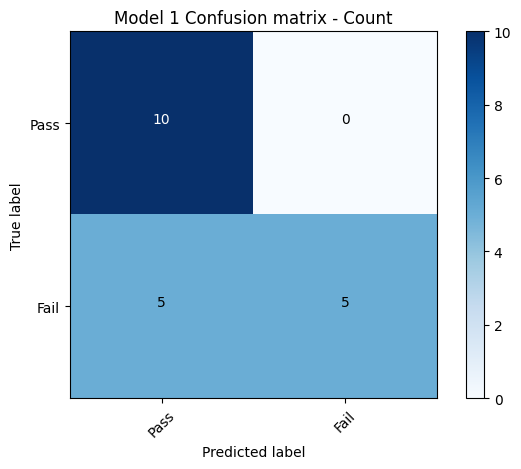

In [17]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Pass','Fail'],
                      title='Model 1 Confusion matrix - Count')

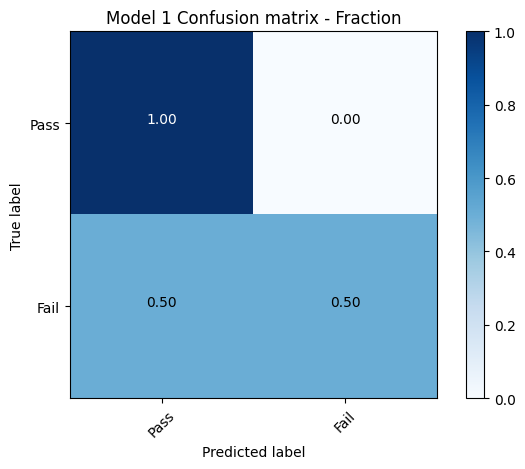

In [18]:
# Plot normalized confusion matrix (numbers are shown as a fraction)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Pass','Fail'],
                      title='Model 1 Confusion matrix - Fraction',normalize=True)

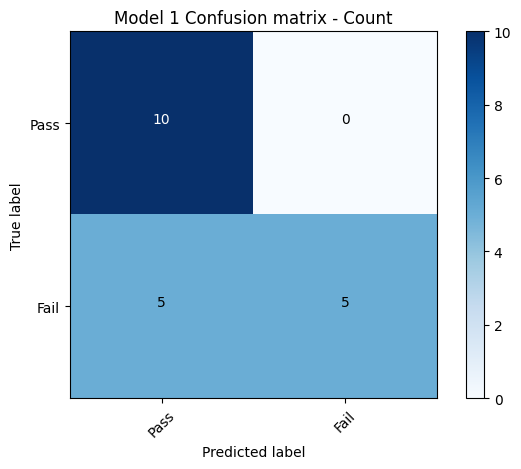

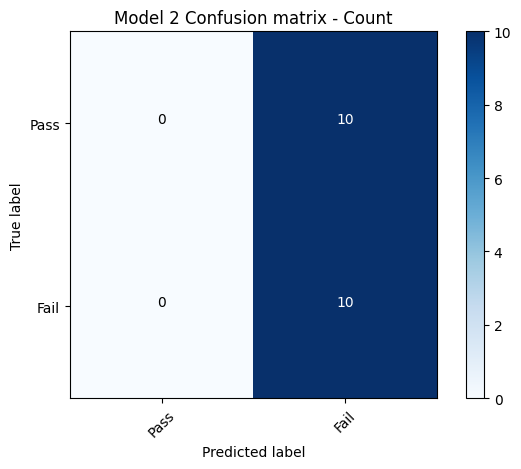

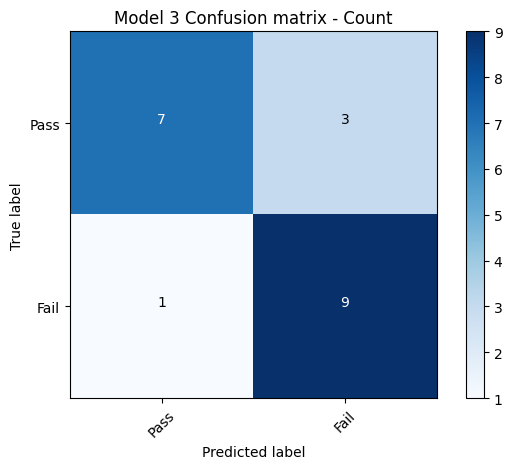

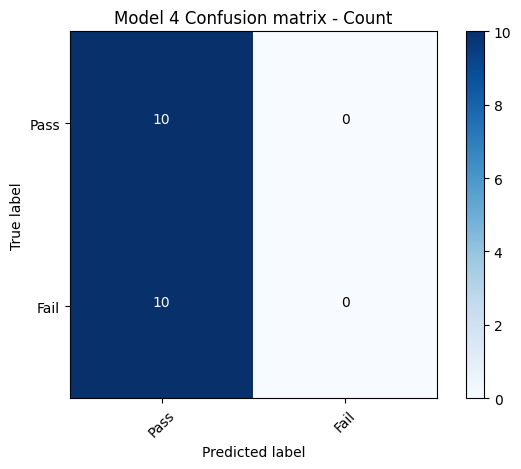

In [19]:
# Plot confusion matrix
# Show actual counts
for model in models:
    #print(model)
    cnf_matrix = confusion_matrix(df['Pass'],
                                  df[model.replace(' ','') + '_Prediction'],labels=[1,0])
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['Pass','Fail'],
                      title= model + ' Confusion matrix - Count', normalize=False)

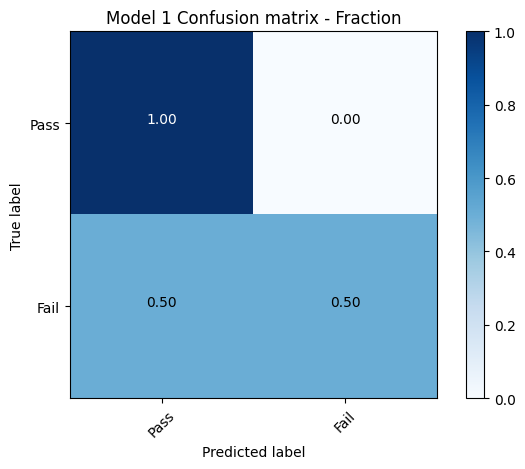

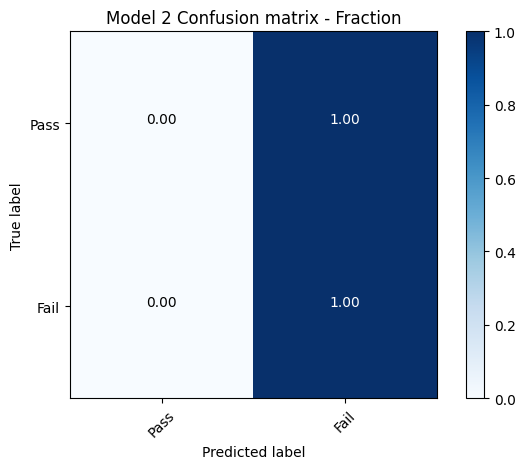

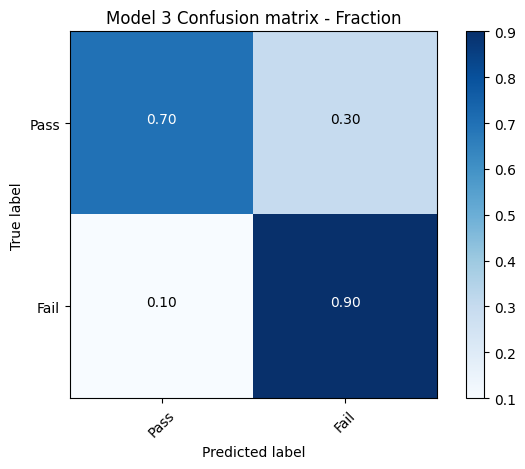

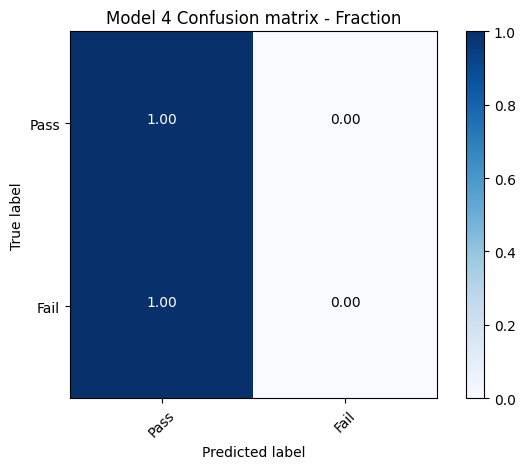

In [20]:
# Compute confusion matrix
# Show Fraction
for model in models:
    #print(model)
    cnf_matrix = confusion_matrix(df['Pass'],
                                  df[model.replace(' ','') + '_Prediction'],labels=[1,0])
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['Pass','Fail'],
                      title= model + ' Confusion matrix - Fraction', normalize=True)

In [21]:
# Compute Metrics for all models
all_metrics = []
for model in models:
    print(model)
    colname = model.replace(' ','') + '_Prediction'

    metrics = binary_classifier_metrics(df['Pass'],df[colname])
    all_metrics.append(metrics)

Model 1
Model 2
Model 3
Model 4


In [22]:
# Create a metrics dataframe
# https://stackoverflow.com/questions/41168558/python-how-to-convert-json-file-to-dataframe/41168691
df_metrics=pd.DataFrame.from_dict(all_metrics)
df_metrics.index = models

In [23]:
print('Counts')
print(df_metrics[['TruePositive',
                  'FalseNegative',
                  'FalsePositive',
                  'TrueNegative',]].round(2))
print()
print('Ratios')
print(df_metrics[['Recall',
                  'FalseNegativeRate',
                  'FalsePositiveRate',
                  'TrueNegativeRate',]].round(2))
print()

print(df_metrics[['Precision',
                  'Accuracy',
                  'F1']].round(2))

Counts
         TruePositive  FalseNegative  FalsePositive  TrueNegative
Model 1            10              0              5             5
Model 2             0             10              0            10
Model 3             7              3              1             9
Model 4            10              0             10             0

Ratios
         Recall  FalseNegativeRate  FalsePositiveRate  TrueNegativeRate
Model 1     1.0                0.0                0.5               0.5
Model 2     0.0                1.0                0.0               1.0
Model 3     0.7                0.3                0.1               0.9
Model 4     1.0                0.0                1.0               0.0

         Precision  Accuracy    F1
Model 1       0.67      0.75  0.80
Model 2       0.00      0.50  0.00
Model 3       0.88      0.80  0.78
Model 4       0.50      0.50  0.67


<h2>Compute Metrics using SKLearn Classification Report</h2>

In [24]:
# Using SKLearn classification report
# Micro Average Vs Macro Average
# https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
for model in models:
    print(model)
    print(classification_report(
    df['Pass'],
    df[model.replace(' ','') + '_Prediction'],
    labels=[1,0],
    target_names=['Pass','Fail']))

Model 1
              precision    recall  f1-score   support

        Pass       0.67      1.00      0.80        10
        Fail       1.00      0.50      0.67        10

    accuracy                           0.75        20
   macro avg       0.83      0.75      0.73        20
weighted avg       0.83      0.75      0.73        20

Model 2
              precision    recall  f1-score   support

        Pass       0.00      0.00      0.00        10
        Fail       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20

Model 3
              precision    recall  f1-score   support

        Pass       0.88      0.70      0.78        10
        Fail       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

<h2>Summary</h2>
From these metrics, we can see that Model 1 and Model 3 are performing better than Model 2 and 4.


Model 1 has higher Recall (it correctly identifies more positive samples) at the cost of higher False Positive Rate (negative samples were misclassified as positive)

Model 3 offers balanced performance